<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/MnistPyTorch_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Neural Net using PyTorch on MNIST
* Using only 2 hidden layers & Relu activation
* We should be able to hit around 97% accuracy
* A Convnet should do better getting 98%+
* This is a "phase" 1 example to be expanded upon in other notebooks
 * Add validation reporting
 * Abstract details into functions
 * Show effects of other optimizers
 * Show effects of learning rate
 * Add regularization (i.e. we wouldn't want to fit 100 epochs here)
 * Add early stopping for comparison to regularization
 * Show activations in layers




# Setup

In [0]:
import pickle
import gzip
import requests
import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [267]:
torch.__version__

'1.3.1+cu100'

# Data
* Pull in pickled MNIST from http://deeplearning.net/data/mnist/mnist.pkl.gz
* Need to encode with latin1
* train[0] = X, train[1] = y
* Data scaled by 255

In [0]:
r = requests.get('http://deeplearning.net/data/mnist/mnist.pkl.gz')
open('mnist.pkl.gz', 'wb').write(r.content)

with gzip.open('mnist.pkl.gz', 'rb') as f:
  un = pickle._Unpickler(f)
  un.encoding = 'latin1'
  ((X_train, y_train), (X_val, y_val), (X_test, y_test)) = un.load()

# Check Data

In [109]:
X_train.shape, y_train.min(), y_train.max()

((50000, 784), 0, 9)

In [110]:
X_test.shape, y_test.min(), y_test.max()

((10000, 784), 0, 9)

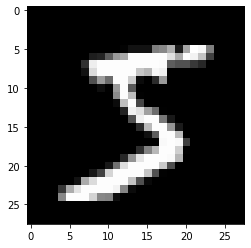

In [111]:
plt.imshow(X_train[0].reshape((28, 28)), cmap='gray')

# DataSet & Loader

In [240]:
X_train, y_train, X_valid, y_valid, X_test, y_test = \
  map(torch.tensor, (X_train, y_train, X_val, y_val, X_test, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [0]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
test_dataset  = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=64)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64)

# Sequential Linear Model

In [282]:
class SimpleNN(nn.Module):
  def __init__(self,) :
    super().__init__()
    self.fc1 = nn.Linear(784, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, X):
    X = F.relu(self.fc1(X))
    X = self.fc2(X)
    return X

net = SimpleNN()
print(net)

SimpleNN(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


# Optimizer

In [0]:
#SGD Optimizer with Momentum 
#  Achieves about 96% given this architecture
#learning_rate = 1e-3
#epochs = 50
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

#Adam Optimizer
#  Achives about 97% given this architecture
learning_rate = 1e-3
epochs = 100
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

 # Gradient Descent - Learning

In [284]:
logging_interval = 100
losses = []

for epoch in range(epochs):
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    data = data.view(-1, 784)
    optimizer.zero_grad()
    n_out = net(data)
    loss = criterion(n_out, target)
    loss.backward()
    optimizer.step()
    if batch_idx % logging_interval == 0:
      losses.append(loss)
  print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch, loss.data))

Train Epoch: 0	Loss: 0.098062
Train Epoch: 1	Loss: 0.403634
Train Epoch: 2	Loss: 0.111727
Train Epoch: 3	Loss: 0.516557
Train Epoch: 4	Loss: 0.094903
Train Epoch: 5	Loss: 0.340874
Train Epoch: 6	Loss: 0.023409
Train Epoch: 7	Loss: 0.013246
Train Epoch: 8	Loss: 0.051106
Train Epoch: 9	Loss: 0.008165
Train Epoch: 10	Loss: 0.011514
Train Epoch: 11	Loss: 0.001172
Train Epoch: 12	Loss: 0.004350
Train Epoch: 13	Loss: 0.003322
Train Epoch: 14	Loss: 0.023847
Train Epoch: 15	Loss: 0.109480
Train Epoch: 16	Loss: 0.015653
Train Epoch: 17	Loss: 0.060912
Train Epoch: 18	Loss: 0.033145
Train Epoch: 19	Loss: 0.023343
Train Epoch: 20	Loss: 0.009889
Train Epoch: 21	Loss: 0.000487
Train Epoch: 22	Loss: 0.003738
Train Epoch: 23	Loss: 0.026467
Train Epoch: 24	Loss: 0.011177
Train Epoch: 25	Loss: 0.005761
Train Epoch: 26	Loss: 0.001522
Train Epoch: 27	Loss: 0.012732
Train Epoch: 28	Loss: 0.015990
Train Epoch: 29	Loss: 0.010173
Train Epoch: 30	Loss: 0.000829
Train Epoch: 31	Loss: 0.006538
Train Epoch: 32	Lo

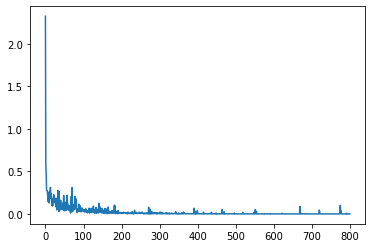

In [285]:
plt.plot(losses)

# Test

In [287]:
test_loss = 0
correct   = 0

for data, target in test_loader:
  data, target = Variable(data), Variable(target)
  net_out = net(data)
  test_loss += criterion(net_out, target)
  pred = net_out.data.max(1)[1]
  correct += pred.eq(target.data).sum()

test_loss /= len(test_loader.dataset)
print('Test Set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)
))

Test Set: Average loss: 0.0023, Accuracy: 9702/10000 (97%)
